# 演示如何使用 openai function calling特性

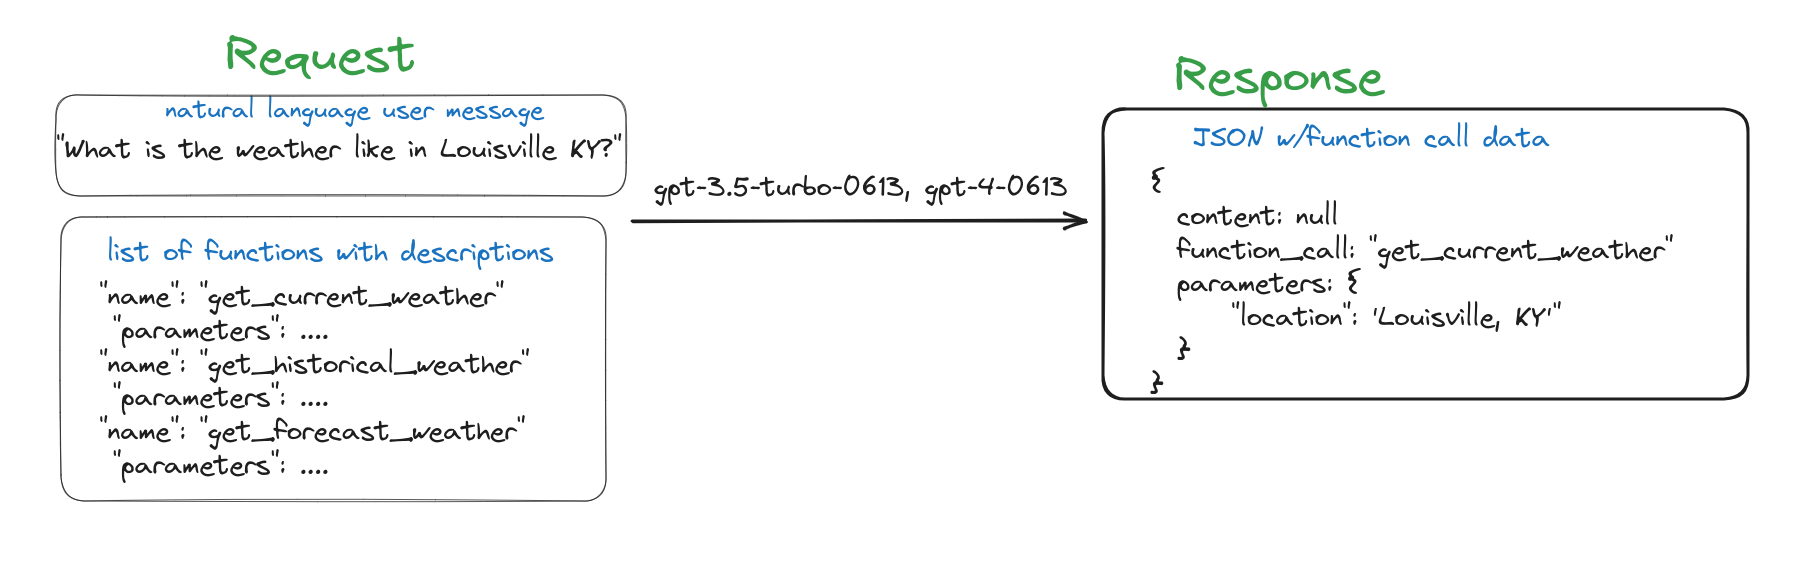

## 1.使用代理

In [16]:
import os
import socket
import socks

socks.set_default_proxy(socks.SOCKS5, "127.0.0.1", 10808)
socket.socket = socks.socksocket

## 2.访问天气的代码

In [48]:
import requests

xinzhi_api_key = "SzM6UhCGvmSWPwOJz"

def get_current_weather(location: str, unit: str='c'):
    url = f"https://api.seniverse.com/v3/weather/now.json?key={xinzhi_api_key}&location={location}&language=zh-Hans&unit={unit}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        weather = {
            "temperature": data["results"][0]["now"]["temperature"],
            "description": data["results"][0]["now"]["text"],
        }
        return weather
    else:
        raise Exception(
            f"Failed to retrieve weather: {response.status_code}")

In [50]:
get_current_weather('喀什市')

{'temperature': '19', 'description': '多云'}

## 3.function calling 代码实现

In [78]:
from openai import OpenAI

messages = [{"role": "system", "content": "根据用户信息，调用对应的工具。"},
            {"role": "user", "content": "今天武汉下雨吗？"}]
functions = [
    {
        "name": "get_current_weather",
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city name ot the location, e.g. San Francisco",
                },
                "unit": {"type": "string", "enum": ["c", "f"]},
            },
            "required": ["location"],
        },
    }
]
client = OpenAI()
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=functions,
    function_call="auto",  # auto is default, but we'll be explicit
)
print(response)

ChatCompletion(id='chatcmpl-97yb2uFuuf2A7CxiLzT7Qz3eKi4xr', choices=[Choice(finish_reason='function_call', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=FunctionCall(arguments='{\n  "location": "武汉"\n}', name='get_current_weather'), tool_calls=None))], created=1711688256, model='gpt-3.5-turbo-0613', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=19, prompt_tokens=98, total_tokens=117))


In [79]:
import json

response_message = response.choices[0].message
function_args = json.loads(response_message.function_call.arguments)
function_args

{'location': '武汉'}

In [82]:
import json

response_message = response.choices[0].message
function_args = json.loads(response_message.function_call.arguments)


# Note: the JSON response may not always be valid; be sure to handle errors
available_functions = {
    "get_current_weather": get_current_weather,
}  

# only one function in this example, but you can have multiple
function_name = response_message.function_call.name
fuction_to_call = available_functions[function_name]
function_response = fuction_to_call(
    location=function_args.get("location"),
    #unit=function_args.get("unit"),
)
print(function_response)

{'temperature': '26', 'description': '晴'}
